In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
import xgboost as xgb
import optuna

Данная часть выполнялась на ресурсе kaggle:
- Объединенные данные из условия: https://www.kaggle.com/datasets/maxigitov/alfa-hack-full?select=train.csv
- Сабмит: https://www.kaggle.com/datasets/maxigitov/submit-test

In [5]:
data_train = pd.read_csv(r'/kaggle/input/alfa-hack-full/train.csv')
data_test = pd.read_csv(r'/kaggle/input/alfa-hack-full/test.csv')

In [6]:
data_train.tail()

,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418
30979,0,1.043308,-0.690403,0.0,1.215620,1.421719,0.598994,0.007990,0.140283,-0.041255,...,0.995662,-0.303057,0.0,0.125437,-0.674921,0.180835,0.615623,-0.009903,0.223089,1.170621
30980,0,-0.721967,0.782564,0.0,0.828244,1.391864,1.305206,1.831460,-0.189084,-0.090508,...,-1.258429,-1.273924,0.0,-1.491329,-0.573189,1.571329,1.236595,0.318531,0.379383,-1.242737
30981,0,0.327923,0.008755,0.0,0.089803,-1.014434,-0.080988,1.337855,0.915741,-1.956219,...,-0.052526,1.011136,0.0,-0.865690,0.087085,0.254712,0.046566,0.644978,-1.726464,-0.073747
30982,0,-0.462936,0.069798,1.0,0.498833,-0.516665,-0.277629,0.590845,-1.313442,0.660018,...,-0.883955,0.101870,1.0,0.047438,-0.933236,1.058533,1.765352,1.351902,-1.051729,-0.392565
30983,0,0.528024,-0.483061,0.0,1.046779,-2.269020,1.025264,0.669237,-1.202967,0.722394,...,0.675119,-0.019827,0.0,1.547347,0.742589,1.428528,0.441147,0.328823,0.424369,-0.081960


Удаляем колокни согласно ноутбуку: feature_importence_selections

In [7]:
col_to_drop = ['feature_3', 'feature_5', 'feature_10', 'feature_14', 'feature_15',
       'feature_17', 'feature_20', 'feature_22', 'feature_23',
       'feature_26', 'feature_36', 'feature_43', 'feature_46',
       'feature_48', 'feature_49', 'feature_54', 'feature_55',
       'feature_70', 'feature_77', 'feature_89', 'feature_92',
       'feature_98', 'feature_101', 'feature_115', 'feature_125',
       'feature_126', 'feature_130', 'feature_132', 'feature_133',
       'feature_135', 'feature_149', 'feature_151', 'feature_153',
       'feature_155', 'feature_156', 'feature_157', 'feature_181',
       'feature_187', 'feature_203', 'feature_206', 'feature_207',
       'feature_210', 'feature_231', 'feature_240', 'feature_242',
       'feature_244', 'feature_248', 'feature_252', 'feature_255',
       'feature_270', 'feature_287', 'feature_292', 'feature_308',
       'feature_330', 'feature_341', 'feature_348', 'feature_350',
       'feature_352', 'feature_368', 'feature_372', 'feature_381',
       'feature_396', 'feature_404', 'feature_405', 'feature_406',
       'feature_410', 'feature_411', 'feature_415'] + ['feature_4',
       'feature_12', 'feature_25', 'feature_57',
       'feature_60', 'feature_66', 'feature_72', 'feature_82',
       'feature_91', 'feature_102', 'feature_105', 'feature_137',
       'feature_142', 'feature_165', 'feature_176', 'feature_179',
       'feature_197', 'feature_198', 'feature_200', 'feature_246',
       'feature_249', 'feature_254', 'feature_262', 'feature_276',
       'feature_289', 'feature_299', 'feature_305', 'feature_306',
       'feature_312', 'feature_322', 'feature_337', 'feature_342',
       'feature_347', 'feature_367', 'feature_393']

In [8]:
data_filtered_train = data_train.drop(columns=col_to_drop)
data_filtered_test = data_test.drop(columns=col_to_drop)

В время решения подбор гиперпараметров optuna осуществлялся через представленную сетку. К сложалению, подобранные гиперпараметры модели для фильтрации были утеряны, поэтому воззможна погрешность. Однако отфильтрованные колонки сохранить удалось

## Feature filtration by permutation importance

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
import xgboost as xgb
import optuna

def train_and_evaluate_xgboost(data_train, data_test, n_trials=20, timeout=600):
    # Проверка наличия целевой переменной и разделение данных
    if 'target' in data_train.columns and 'target' in data_test.columns:
        X_train = data_train.drop(columns=['target'])
        y_train = data_train['target']
        X_test = data_test.drop(columns=['target'])
        y_test = data_test['target']
    else:
        raise ValueError("Ошибка: отсутствует столбец 'target' в train или test данных.")

    # Определение категориальных признаков
    categorical_columns = [col for col in X_train.columns if X_train[col].nunique() < 30]

    # Кодирование категориальных признаков
    for col in categorical_columns:
        X_train[col] = X_train[col].astype('category').cat.codes
        X_test[col] = X_test[col].astype('category').cat.codes

    def optimize_xgb(trial):
        params = {
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
        }

        model = xgb.XGBClassifier(
            **params,
            objective='binary:logistic',
            n_estimators=500,
            tree_method='gpu_hist',
            gpu_id=0,
            verbosity=0,
            use_label_encoder=False
        )

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train)],
            eval_metric='auc',
            verbose=False
        )

        preds = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, preds)
        return score

    # Создание и запуск Optuna исследований
    def run_optuna(study_name, optimize_function, n_trials=20, timeout=None):
        study = optuna.create_study(direction='maximize', study_name=study_name)
        study.optimize(optimize_function, n_trials=n_trials, timeout=timeout)
        return study.best_params

    # Подбор гиперпараметров
    best_params_xgb = run_optuna('XGBoost', optimize_xgb, n_trials=n_trials, timeout=timeout)
    # best_params_xgb = { 'learning_rate': 0.011608443347858289, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.8111071406017442, 'colsample_bytree': 0.9253272092863656, 'gamma': 0.706494905024926, 'reg_alpha': 1.75928773021309e-07, 'reg_lambda': 2.942601302437469 }
    # Обучение модели с лучшими гиперпараметрами
    xgb_model = xgb.XGBClassifier(
        **best_params_xgb,
        objective='binary:logistic',
        n_estimators=500,
        tree_method='gpu_hist',
        gpu_id=0,
        verbosity=0,
        use_label_encoder=False
    )
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train)],
        eval_metric='auc',
        verbose=False
    )

    # Предсказания модели
    preds_xgb = xgb_model.predict_proba(X_test)[:, 1]

    # Оценка модели
    roc_auc = roc_auc_score(y_test, preds_xgb)
    print(f"ROC-AUC score (без перемешивания): {roc_auc:.4f}")

    # Вычисление Permutation Importance
    perm_importance = permutation_importance(xgb_model, X_test, y_test, scoring='roc_auc', n_repeats=10, random_state=42)

    # Сохранение названий колонок с отрицательным приростом
    negative_importance_columns = [col for col, importance in zip(X_test.columns, perm_importance.importances_mean) if importance < 0]
    
    # Удаление этих колонок из обучающего и тестового наборов
    X_train = X_train.drop(columns=negative_importance_columns)
    X_test = X_test.drop(columns=negative_importance_columns)

    # Сохранение обновленных данных
    data_train_filtered = pd.concat([X_train, y_train], axis=1)
    data_test_filtered = pd.concat([X_test, y_test], axis=1)
    
    data_train_filtered.to_csv('data_train_filtered.csv', index=False)
    data_test_filtered.to_csv('data_test_filtered.csv', index=False)
    
    print(f"Удаленные признаки с отрицательным влиянием: {negative_importance_columns}")
    return roc_auc, negative_importance_columns

# Пример использования функции
roc_auc, negative_importance_columns = train_and_evaluate_xgboost(data_filtered_train, data_filtered_test)

[I 2024-11-15 16:35:42,521] A new study created in memory with name: XGBoost
/tmp/ipykernel_30/628270019.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_30/628270019.py:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_30/628270019.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_30/628270019.py

ROC-AUC score (без перемешивания): 0.7703
Удаленные признаки с отрицательным влиянием: ['feature_1', 'feature_6', 'feature_8', 'feature_9', 'feature_13', 'feature_16', 'feature_18', 'feature_19', 'feature_24', 'feature_27', 'feature_32', 'feature_34', 'feature_38', 'feature_39', 'feature_42', 'feature_44', 'feature_50', 'feature_53', 'feature_59', 'feature_62', 'feature_63', 'feature_69', 'feature_73', 'feature_76', 'feature_79', 'feature_81', 'feature_84', 'feature_87', 'feature_93', 'feature_95', 'feature_107', 'feature_108', 'feature_110', 'feature_111', 'feature_112', 'feature_120', 'feature_123', 'feature_127', 'feature_128', 'feature_134', 'feature_138', 'feature_141', 'feature_143', 'feature_145', 'feature_148', 'feature_158', 'feature_164', 'feature_173', 'feature_177', 'feature_178', 'feature_182', 'feature_183', 'feature_185', 'feature_186', 'feature_189', 'feature_201', 'feature_211', 'feature_212', 'feature_216', 'feature_217', 'feature_225', 'feature_229', 'feature_232', '

Удаляем колонки с отрицательным влиянием

In [10]:
col_to_drop = ['feature_1', 'feature_6', 'feature_8', 'feature_9', 'feature_16', 'feature_19', 'feature_29', 'feature_35', 'feature_37', 'feature_38', 'feature_40', 'feature_44', 'feature_47', 'feature_56', 'feature_59', 'feature_63', 'feature_65', 'feature_71', 'feature_73', 'feature_76', 'feature_79', 'feature_80', 'feature_83', 'feature_84', 'feature_85', 'feature_96', 'feature_107', 'feature_112', 'feature_114', 'feature_118', 'feature_123', 'feature_128', 'feature_129', 'feature_138', 'feature_139', 'feature_141', 'feature_143', 'feature_148', 'feature_152', 'feature_154', 'feature_158', 'feature_160', 'feature_161', 'feature_162', 'feature_169', 'feature_172', 'feature_173', 'feature_178', 'feature_182', 'feature_183', 'feature_185', 'feature_186', 'feature_191', 'feature_202', 'feature_204', 'feature_205', 'feature_211', 'feature_213', 'feature_214', 'feature_216', 'feature_217', 'feature_218', 'feature_223', 'feature_225', 'feature_226', 'feature_229', 'feature_232', 'feature_234', 'feature_236', 'feature_238', 'feature_243', 'feature_250', 'feature_257', 'feature_259', 'feature_261', 'feature_264', 'feature_265', 'feature_266', 'feature_268', 'feature_272', 'feature_273', 'feature_275', 'feature_277', 'feature_280', 'feature_286', 'feature_293', 'feature_297', 'feature_298', 'feature_301', 'feature_303', 'feature_304', 'feature_309', 'feature_311', 'feature_314', 'feature_316', 'feature_317', 'feature_318', 'feature_323', 'feature_332', 'feature_334', 'feature_335', 'feature_351', 'feature_353', 'feature_355', 'feature_359', 'feature_361', 'feature_363', 'feature_365', 'feature_366', 'feature_369', 'feature_373', 'feature_376', 'feature_377', 'feature_380', 'feature_382', 'feature_385', 'feature_389', 'feature_391', 'feature_392', 'feature_394', 'feature_398', 'feature_399', 'feature_401', 'feature_407', 'feature_408', 'feature_413', 'feature_414', 'feature_417']

Удалим колонки, которые дают отрицательный прирост целевой метрики

In [11]:
data_filtered_train = data_filtered_train.drop(columns=col_to_drop)
data_filtered_test = data_filtered_test.drop(columns=col_to_drop)

## Подбор гиперпараметров optuna и обучение на train

Подобранные параметры для лучшей модели: 
- { 'learning_rate': 0.011608443347858289, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.8111071406017442, 'colsample_bytree': 0.9253272092863656, 'gamma': 0.706494905024926, 'reg_alpha': 1.75928773021309e-07, 'reg_lambda': 2.942601302437469 }

In [15]:
def train_and_evaluate_xgboost(data_train, data_test, n_trials=500, timeout=1000000):
    # Проверка наличия целевой переменной и разделение данных
    if 'target' in data_train.columns and 'target' in data_test.columns:
        X_train = data_train.drop(columns=['target'])
        y_train = data_train['target']
        X_test = data_test.drop(columns=['target'])
        y_test = data_test['target']
    else:
        raise ValueError("Ошибка: отсутствует столбец 'target' в train или test данных.")

    # Определение категориальных признаков
    categorical_columns = [col for col in X_train.columns if X_train[col].nunique() < 30]

    # Кодирование категориальных признаков
    for col in categorical_columns:
        X_train[col] = X_train[col].astype('category').cat.codes
        X_test[col] = X_test[col].astype('category').cat.codes

    def optimize_xgb(trial):
        params = {
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
        }

        model = xgb.XGBClassifier(
            **params,
            objective='binary:logistic',
            n_estimators=500,
            gpu_id=0,
            verbosity=0,
            use_label_encoder=False
        )

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train)],
            eval_metric='auc',
            verbose=False
        )

        preds = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, preds)
        return score

    # Создание и запуск Optuna исследований
    def run_optuna(study_name, optimize_function, n_trials=500, timeout=None):
        study = optuna.create_study(direction='maximize', study_name=study_name)
        study.optimize(optimize_function, n_trials=n_trials, timeout=timeout)
        return study.best_params

    # Подбор гиперпараметров
    # best_params_xgb = run_optuna('XGBoost', optimize_xgb, n_trials=n_trials, timeout=timeout)
    best_params_xgb = { 'learning_rate': 0.011608443347858289, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.8111071406017442, 'colsample_bytree': 0.9253272092863656, 'gamma': 0.706494905024926, 'reg_alpha': 1.75928773021309e-07, 'reg_lambda': 2.942601302437469 }
    # Обучение модели с лучшими гиперпараметрами
    xgb_model = xgb.XGBClassifier(
        **best_params_xgb,
        objective='binary:logistic',
        n_estimators=500,
        gpu_id=0,
        verbosity=0,
        use_label_encoder=False
    )
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train)],
        eval_metric='auc',
        verbose=False
    )

    # Предсказания модели
    preds_xgb = xgb_model.predict_proba(X_test)[:, 1]

    # Оценка модели
    roc_auc = roc_auc_score(y_test, preds_xgb)
    return roc_auc

print(train_and_evaluate_xgboost(data_filtered_train, data_filtered_test))

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


0.8144927597810939


Для воспроизводимости фиксируем подобранные гиперпараметры: 
- { 'learning_rate': 0.011608443347858289, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.8111071406017442, 'colsample_bytree': 0.9253272092863656, 'gamma': 0.706494905024926, 'reg_alpha': 1.75928773021309e-07, 'reg_lambda': 2.942601302437469 }

## Обучение на train+test и сохранение сабмита

In [16]:
import pandas as pd
import xgboost as xgb

def train_and_submit_xgboost(data_train, data_test):
    # Проверка наличия целевой переменной и разделение данных
    data_train = pd.concat([data_train, data_test], ignore_index=True)
    if 'target' in data_train.columns:
        X = data_train.drop(columns=['target'])
        y = data_train['target']
    else:
        raise ValueError("Ошибка: отсутствует столбец 'target' в train данных.")

    # Определение категориальных признаков
    categorical_columns = [col for col in X.columns if X[col].nunique() < 30]

    # Кодирование категориальных признаков
    for col in categorical_columns:
        X[col] = X[col].astype('category').cat.codes

    # Полобранные параметры для XGBoost
    best_params_xgb = { 'learning_rate': 0.011608443347858289, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.8111071406017442, 'colsample_bytree': 0.9253272092863656, 'gamma': 0.706494905024926, 'reg_alpha': 1.75928773021309e-07, 'reg_lambda': 2.942601302437469 }

    # Обучение модели на всех данных
    xgb_model = xgb.XGBClassifier(
        **best_params_xgb,
        objective='binary:logistic',
        n_estimators=500,
        gpu_id=0,
        verbosity=0,
        use_label_encoder=False
    )
    xgb_model.fit(X, y)
    data_test_subm = pd.read_csv(r"/kaggle/input/submit-test/submit_test (1).csv")
    # Подготовка тестовых данных для сабмита
    columns_to_drop = ['feature_3', 'feature_5', 'feature_10', 'feature_14', 'feature_15',
       'feature_17', 'feature_20', 'feature_22', 'feature_23',
       'feature_26', 'feature_36', 'feature_43', 'feature_46',
       'feature_48', 'feature_49', 'feature_54', 'feature_55',
       'feature_70', 'feature_77', 'feature_89', 'feature_92',
       'feature_98', 'feature_101', 'feature_115', 'feature_125',
       'feature_126', 'feature_130', 'feature_132', 'feature_133',
       'feature_135', 'feature_149', 'feature_151', 'feature_153',
       'feature_155', 'feature_156', 'feature_157', 'feature_181',
       'feature_187', 'feature_203', 'feature_206', 'feature_207',
       'feature_210', 'feature_231', 'feature_240', 'feature_242',
       'feature_244', 'feature_248', 'feature_252', 'feature_255',
       'feature_270', 'feature_287', 'feature_292', 'feature_308',
       'feature_330', 'feature_341', 'feature_348', 'feature_350',
       'feature_352', 'feature_368', 'feature_372', 'feature_381',
       'feature_396', 'feature_404', 'feature_405', 'feature_406',
       'feature_410', 'feature_411', 'feature_415'] + ['feature_4',
       'feature_12', 'feature_25', 'feature_57',
       'feature_60', 'feature_66', 'feature_72', 'feature_82',
       'feature_91', 'feature_102', 'feature_105', 'feature_137',
       'feature_142', 'feature_165', 'feature_176', 'feature_179',
       'feature_197', 'feature_198', 'feature_200', 'feature_246',
       'feature_249', 'feature_254', 'feature_262', 'feature_276',
       'feature_289', 'feature_299', 'feature_305', 'feature_306',
       'feature_312', 'feature_322', 'feature_337', 'feature_342',
       'feature_347', 'feature_367', 'feature_393'] + ['feature_1', 'feature_6', 'feature_8', 'feature_9', 'feature_16', 'feature_19', 'feature_29', 'feature_35', 'feature_37', 'feature_38', 'feature_40', 'feature_44', 'feature_47', 'feature_56', 'feature_59', 'feature_63', 'feature_65', 'feature_71', 'feature_73', 'feature_76', 'feature_79', 'feature_80', 'feature_83', 'feature_84', 'feature_85', 'feature_96', 'feature_107', 'feature_112', 'feature_114', 'feature_118', 'feature_123', 'feature_128', 'feature_129', 'feature_138', 'feature_139', 'feature_141', 'feature_143', 'feature_148', 'feature_152', 'feature_154', 'feature_158', 'feature_160', 'feature_161', 'feature_162', 'feature_169', 'feature_172', 'feature_173', 'feature_178', 'feature_182', 'feature_183', 'feature_185', 'feature_186', 'feature_191', 'feature_202', 'feature_204', 'feature_205', 'feature_211', 'feature_213', 'feature_214', 'feature_216', 'feature_217', 'feature_218', 'feature_223', 'feature_225', 'feature_226', 'feature_229', 'feature_232', 'feature_234', 'feature_236', 'feature_238', 'feature_243', 'feature_250', 'feature_257', 'feature_259', 'feature_261', 'feature_264', 'feature_265', 'feature_266', 'feature_268', 'feature_272', 'feature_273', 'feature_275', 'feature_277', 'feature_280', 'feature_286', 'feature_293', 'feature_297', 'feature_298', 'feature_301', 'feature_303', 'feature_304', 'feature_309', 'feature_311', 'feature_314', 'feature_316', 'feature_317', 'feature_318', 'feature_323', 'feature_332', 'feature_334', 'feature_335', 'feature_351', 'feature_353', 'feature_355', 'feature_359', 'feature_361', 'feature_363', 'feature_365', 'feature_366', 'feature_369', 'feature_373', 'feature_376', 'feature_377', 'feature_380', 'feature_382', 'feature_385', 'feature_389', 'feature_391', 'feature_392', 'feature_394', 'feature_398', 'feature_399', 'feature_401', 'feature_407', 'feature_408', 'feature_413', 'feature_414', 'feature_417']
    data_test_subm = data_test_subm.drop(columns=columns_to_drop)
    
    # Предсказания для тестовых данных
    preds_xgb_subm = xgb_model.predict_proba(data_test_subm.drop(['smpl', 'id'], axis=1))[:, 1]
    data_test_subm['target'] = pd.Series(preds_xgb_subm)

    # Создание файла сабмита
    data_test_subm[['id', 'target']].to_csv('baseline_submission_case3.csv', index=False)

# Использование функции
train_and_submit_xgboost(data_filtered_train, data_filtered_test)

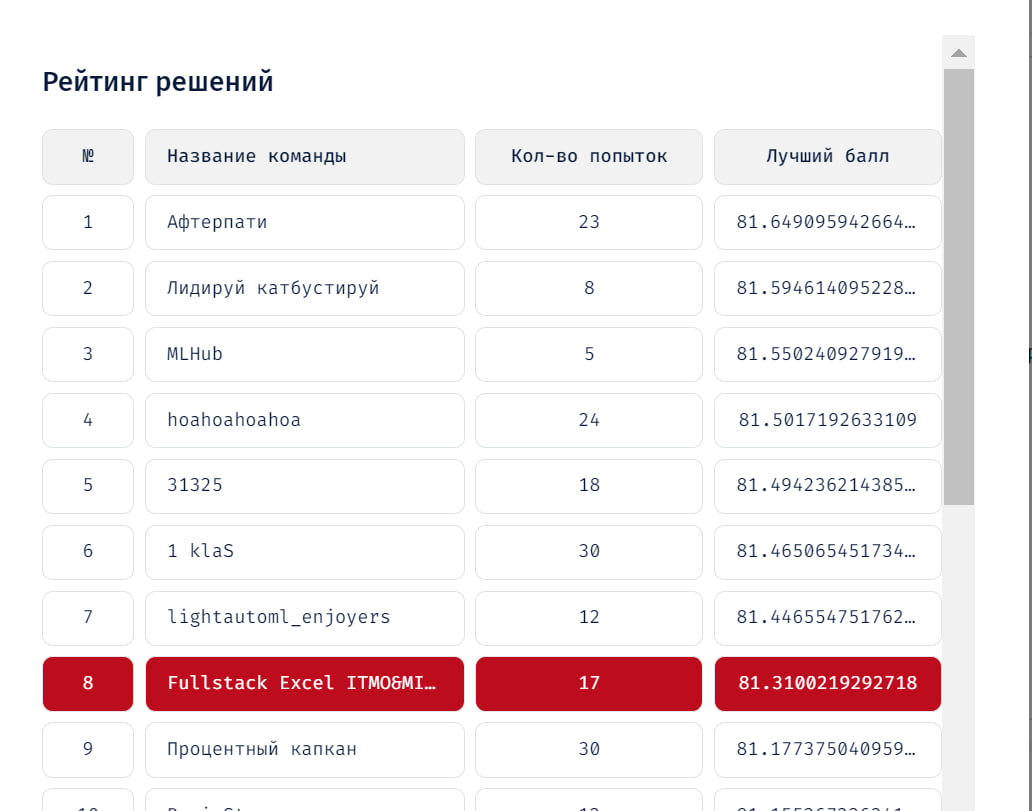
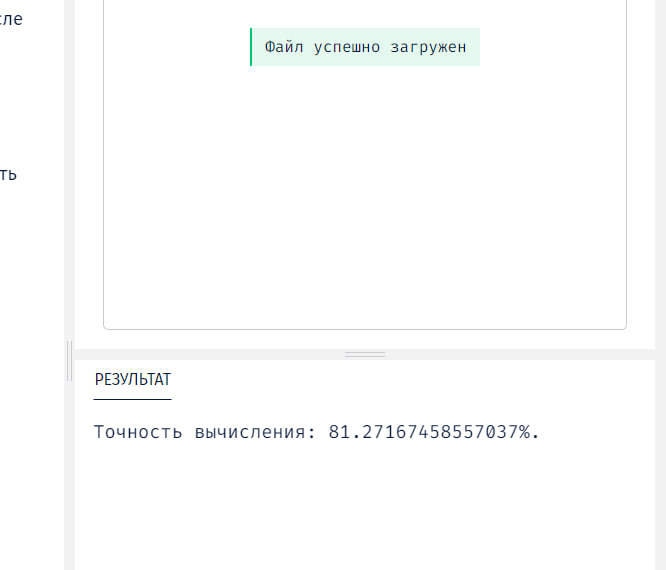
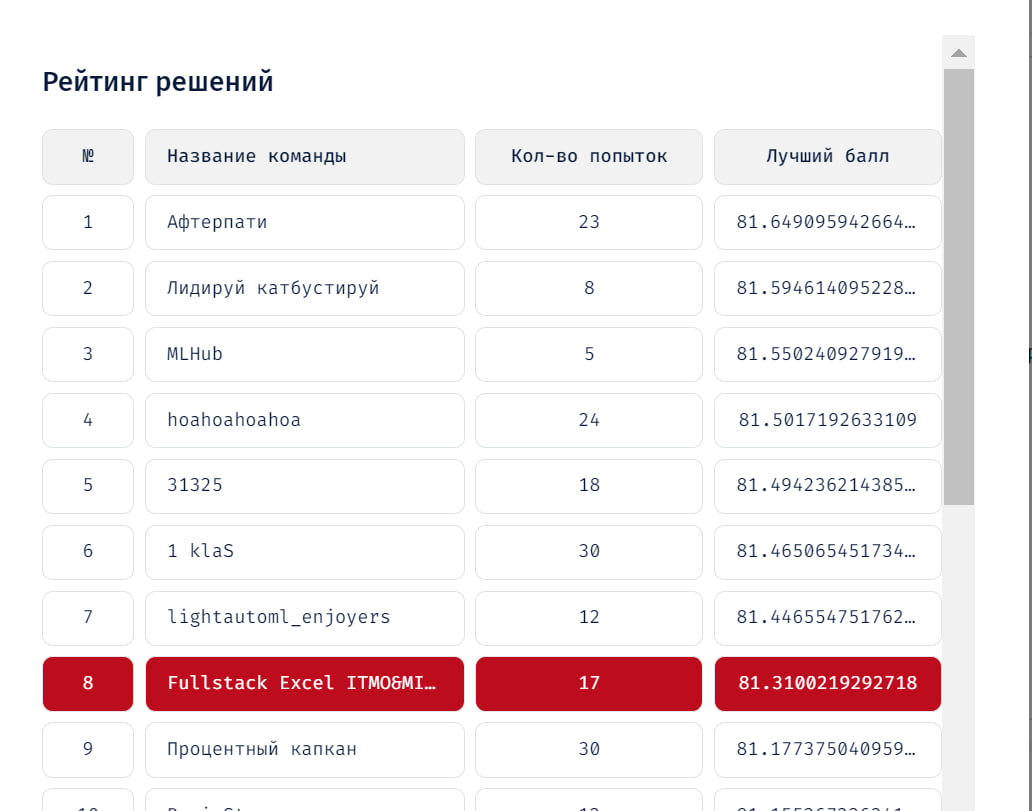